# Topic Modeling — Time Series

In this notebook, we're learning about a text analysis method called *topic modeling*. This method will help us identify the main topics or discourses within a collection of texts or single text that has been separated into smaller text chunks. So what is topic modeling?

When we calculated term frequency-inverse document frequency (tf-idf) scores, we identified individual words that were statistically meaningful for certain documents (i.e., they were more likely to show up in certain documents rather than in other ones). When we topic model, we’re going to identify clusters of words that show up together in statistically meaningful ways throughout the corpus.

Topic models are useful for understanding collections of texts in their broadest outlines and themes. If you wanted to get a sense of the primary subjects discussed in thousands of journal articles published over multiple decades, then topic modeling might be a good choice. Topic models can also be helpful for looking at the fluctuation of topics and themes over time or finding clusters of texts that contain the same or similar topics.

## So how does it work?

Without going into too much detail, topic modeling is done using an algorithm. This algorithm determines which words are likely related to each other by checking if they are "clustered" together in texts. If some words keep showing up in the same sentence, in similar paragraphs, in similar documents, than the algorithm will likely discover that these words form a cluster of words that are related to each other. What we call a “topic” is really just a list of the most probable words for that topic, which are sorted in descending order of probability. The most probable word for the topic is the first word. Topic models start to get more powerful when we, as human researchers, analyze the most probable words for every topic and summarize what these words have in common. This summary can then be used as a descriptive label for the topic. The algorithm only determined which words should be clustered together, but doesn’t know what these words mean in relationship to one another. It’s up to us, as the human researchers, to make meaning out of the topics.

Here is an example, let's assume the algorithm determined the following cluster of words with high probability of forming one topic:

> [‘president’, ‘state’, ‘court’, ‘roosevelt’, ‘justice’, ‘house’, ‘years’, ‘law’, ‘party’, ‘political’, ‘republican’, ‘senator’, ‘governor’, ‘democratic’, ‘campaign’]

Then president is the most leading (NL: Toonaangevende) word for the cluster of words forming this topic. However, when analyzing these words you might come up with a better word describing the topic of these words. For instance; Politics.

Here is another cluster of words resulting from a topic modeling algorithm:

> [‘miss’, ‘film’, ‘years’, ‘theater’, ‘broadway’, ‘movie’, ‘films’, ‘hollywood’, ‘stage’, ‘movies’, ‘actor’, ‘new’, ‘director’, ‘york’, ‘show’]

How would you brand this cluster of words / topic?


## Dataset

We are going to apply topic modeling to the tweets of Donald Trump, former president of the United States. What are the topics he is talking about and how do these change over time?

### Trump's Tweets

<blockquote class="epigraph" style=" padding: 10px">

I hear that Fake News CNN just reported that I am isolated in the White House wondering out loud “when will life return to normal?” Does anybody really believe that?

<p class ="attribution">
    —Donald Trump, <a href="https://twitter.com/realdonaldtrump/status/1242929613262725122?lang=en">March 25, 2020 tweet</a>
    </p>
    
</blockquote>

In this particular lesson, we're going to use [Little MALLET Wrapper](https://github.com/maria-antoniak/little-mallet-wrapper), a Python wrapper for [MALLET](http://mallet.cs.umass.edu/topics.php), to topic model a CSV file of Donald Trump's tweets and plot the fluctuation of topics over time. The Trump tweets dataset is downloaded from [The Trump Twitter Archive](https://www.thetrumparchive.com/).

___

## Set MALLET Path

We're going to make a variable called `path_to_mallet` and assign it the file path of our MALLET program. We need to point it, specifically, to the "mallet" file inside the "bin" folder inside the "mallet-2.0.8" folder. 

In [1]:
path_to_mallet = '../../requisites/mallet-2.0.8/bin/mallet'

If MALLET is located in another directory, then set your `path_to_mallet` to that file path.

## Install Packages

In [2]:
!pip install little_mallet_wrapper
!pip install seaborn

## Import Packages

Now let's `import` the `little_mallet_wrapper` and the data visualisation library `seaborn`.

In [3]:
import little_mallet_wrapper
import seaborn
import glob
from pathlib import Path
import pandas as pd
import random
pd.options.display.max_colwidth = 100

We're also going to import [`glob`](https://docs.python.org/3/library/glob.html) and [`pathlib`](https://docs.python.org/3/library/pathlib.html#basic-use) for working with files and the file system, as well as pandas for working with the CSV data.

## Get Training Data From CSV File

Before we topic model Donald Trump's tweets, we need to process the tweets and prepare them for analysis. The steps below demonstrate how to process texts if they come from a CSV file. We're calling these text files our *training data*, because we're *training* our topic model with these texts. The topic model will be learning and extracting topics based on these texts.
    

## Trump Tweets

This dataset of Donald Trump's tweets is taken from [Trump Twitter Archive](http://www.trumptwitterarchive.com/). To read in the CSV file, we're going to use Pandas.

In [4]:
trump_df = pd.read_csv("../../data/processed/tweets/Trump-Tweets_2009-2021.csv", encoding='utf-8')

In [5]:
trump_df.head()

id  \
0  1.347570e+18   
1  1.347560e+18   
2  1.347330e+18   
3  1.346950e+18   
4  1.346930e+18   

                                                                                                  text  \
0             To all of those who have asked, I will not be going to the Inauguration on January 20th.   
1  The 75,000,000 great American Patriots who voted for me, AMERICA FIRST, and MAKE AMERICA GREAT A...   
2                                                                              https://t.co/csX07ZVWGe   
3  These are the things and events that happen when a sacred landslide election victory is so uncer...   
4                                                                              https://t.co/Pm2PKV0Fp3   

  isRetweet isDeleted                device  favorites  retweets  \
0         f         f    Twitter for iPhone     510761     83532   
1         f         f    Twitter for iPhone     480997    108844   
2         f         f  Twitter Media Studio     629326    154877   
3         f         f    Twitter for iPhone          0         0   
4         f         f    Twitter for iPhone          0         0   

           date isFlagged  
0  1/8/21 15:44         f  
1  1/8/21 14:46         f  
2   1/8/21 0:10         f  
3  1/6/21 23:01         f  
4  1/6/21 21:17         f

In [6]:
trump_df['text'] = trump_df['text'].astype(str)

### Process Trump Tweets

In [7]:
training_data = [little_mallet_wrapper.process_string(text, numbers='remove') for text in trump_df['text']]

### Get Original Trump Tweets

In [8]:
original_trump_tweets = [title for title in trump_df['text']]

### Get Dataset Statistics

In [9]:
little_mallet_wrapper.print_dataset_stats(training_data)

Number of Documents: 56571
Mean Number of Words per Document: 12.0
Vocabulary Size: 59952


## Training the Topic Model

We're going to train our topic model with the `little_mallet_wrapper.train_topic_model()` function.

So we have to set a few things up first.

### Set Number of Topics

We need to make a variable `num_topics` and assign it the number of topics we want returned.

In [10]:
num_topics = 35

### Set Other MALLET File Paths

Then we're going to set a file path where we want all our MALLET topic modeling data to be dumped. 

All the other necessary variables below `output_directory_path` will be automatically created inside this directory.

In [12]:
#Change to your desired output directory
output_directory_path = 'topic-model-output/Trump-Tweets'

#No need to change anything below here
Path(f"{output_directory_path}").mkdir(parents=True, exist_ok=True)

path_to_training_data           = f"{output_directory_path}/training.txt"
path_to_formatted_training_data = f"{output_directory_path}/mallet.training"
path_to_model                   = f"{output_directory_path}/mallet.model.{str(num_topics)}"
path_to_topic_keys              = f"{output_directory_path}/mallet.topic_keys.{str(num_topics)}"
path_to_topic_distributions     = f"{output_directory_path}/mallet.topic_distributions.{str(num_topics)}"

### Train Topic Model

Then we're going to train our topic model with `little_mallet_wrapper.quick_train_topic_model()`. The topic model should take about 1-1.5 minutes to train and complete. If you want it, you can look at your Terminal or PowerShell and see what the model looks like as it's training.

In [13]:
little_mallet_wrapper.quick_train_topic_model(path_to_mallet, output_directory_path, num_topics, training_data)

Importing data...
Complete
Training topic model...


Mallet LDA: 35 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 35
total tokens: 656643
<10> LL/token: -10.26548
<20> LL/token: -9.64892
<30> LL/token: -9.40811
<40> LL/token: -9.29187

0	0.14286	realdonaldtrump thanks love apprenticenbc show celebapprentice great apprentice see wait season back always tonight celebrity ivankatrump celebrityapprentice hope watching nbc 
1	0.14286	border people country wall security law must mexico enforcement southern stop police many work want great help safety attack stand 
2	0.14286	https house great today white thank america honor day women whitehouse nation american family men first every peace make veterans 
3	0.14286	north korea good hurricane see building along ready street meeting local place follow kim wall https soon today may atlantic 
4	0.14286	https thank happy realdonaldtrump trump great birthday new true thanks makeamericagreatagain poll love nice day co/d hero everyone anthony weiner 
5	0.14286	court must immigration re

Complete


([['realdonaldtrump',
   'apprentice',
   'celebapprentice',
   'apprenticenbc',
   'show',
   'celebrity',
   'season',
   'great',
   'nbc',
   'tonight',
   'star',
   'wait',
   'love',
   'celebrityapprentice',
   'http',
   'watch',
   'back',
   'see',
   'sunday',
   'thanks'],
  ['border',
   'wall',
   'immigration',
   'security',
   'illegal',
   'democrats',
   'must',
   'country',
   'mexico',
   'southern',
   'want',
   'borders',
   'crime',
   'stop',
   'laws',
   'people',
   'open',
   'build',
   'get',
   'street'],
  ['https',
   'great',
   'today',
   'american',
   'thank',
   'america',
   'honor',
   'day',
   'god',
   'women',
   'nation',
   'people',
   'men',
   'country',
   'bless',
   'families',
   'whitehouse',
   'americans',
   'united',
   'family'],
  ['north',
   'korea',
   'https',
   'hurricane',
   'kim',
   'fema',
   'south',
   'carolina',
   'great',
   'state',
   'local',
   'florida',
   'first',
   'jong',
   'storm',
   'coast',

## Display Topics and Top Words

In [ ]:
topics = little_mallet_wrapper.load_topic_keys(path_to_topic_keys)

for topic_number, topic in enumerate(topics):
    print(f"✨Topic {topic_number}✨\n\n{topic}\n")

## Display Top Tweets For Topic

## Load Topic Distributions

In [19]:
topic_distributions = little_mallet_wrapper.load_topic_distributions(path_to_topic_distributions)

In [20]:
tweet_dict = dict(zip(training_data, original_trump_tweets))

In [21]:
def display_top_tweets_per_topic(topic_number=0, number_of_documents=5):
    
    print(f"✨Topic {topic_number}✨\n\n{topics[topic_number]}\n")

    for probability, document in little_mallet_wrapper.get_top_docs(training_data, topic_distributions, topic_number, n=number_of_documents):
        print(round(probability, 4), tweet_dict[document] + "\n")
    return

In [25]:
display_top_tweets_per_topic(topic_number=1, number_of_documents=5)

✨Topic 1✨

['jobs', 'economy', 'record', 'ever', 'history', 'years', 'market', 'since', 'best', 'time', 'numbers', 'year', 'unemployment', 'great', 'stock', 'high', 'president', 'new', 'economic', 'https']

0.9608 Stock Market up almost 40% since the Election, with 7 Trillion Dollars of U.S. value built throughout the economy. Lowest unemployment rate in many decades, with Black &amp, Hispanic unemployment lowest in History, and Female unemployment lowest in 21 years. Highest confidence ever!

0.9563 “The unemployment rate remains at a 17-year low of 4.1%. The unemployment rate in manufacturing dropped to 2.6%, the lowest ever recorded. The unemployment rate among Hispanics dropped to 4.7%, the lowest ever recorded...”@SecretaryAcosta @USDOL https://t.co/vou28s0yHN

0.9433 Would be sooo great if the Fed would further lower interest rates and quantitative ease. The Dollar is very strong against other currencies and there is almost no inflation. This is the time to do it. Exports would z

## Show Topic Words in Context of Full Tweet

In [23]:
from IPython.display import Markdown, display
import re

def display_bolded_topic_words_in_context(topic_number=3, number_of_documents=3, custom_words=None):

    print(f"✨Topic {topic_number}✨\n\n{topics[topic_number]}\n")

    for probability, document in little_mallet_wrapper.get_top_docs(training_data, topic_distributions, topic_number, n=number_of_documents):

        probability = f"✨✨✨\n\n**{probability}**"
        original_text = tweet_dict[document]
        original_text_lowered = original_text.lower()
        topic_words = topics[topic_number]
        topic_words = custom_words if custom_words != None else topic_words

        for word in topic_words:
            if word in original_text_lowered:
                original_text = re.sub(f"\\b{word}\\b", f"**{word.upper()}**", original_text, flags=re.I)

        display(Markdown(probability)), display(Markdown(original_text))
    return

In [26]:
display_bolded_topic_words_in_context(topic_number=1, number_of_documents=4)

✨Topic 1✨

['jobs', 'economy', 'record', 'ever', 'history', 'years', 'market', 'since', 'best', 'time', 'numbers', 'year', 'unemployment', 'great', 'stock', 'high', 'president', 'new', 'economic', 'https']



✨✨✨

**0.9607886969575177**

**STOCK** **MARKET** up almost 40% **SINCE** the Election, with 7 Trillion Dollars of U.S. value built throughout the **ECONOMY**. Lowest **UNEMPLOYMENT** rate in many decades, with Black &amp, Hispanic **UNEMPLOYMENT** lowest in **HISTORY**, and Female **UNEMPLOYMENT** lowest in 21 **YEARS**. Highest confidence **EVER**!

✨✨✨

**0.9562956605511918**

“The **UNEMPLOYMENT** rate remains at a 17-**YEAR** low of 4.1%. The **UNEMPLOYMENT** rate in manufacturing dropped to 2.6%, the lowest **EVER** recorded. The **UNEMPLOYMENT** rate among Hispanics dropped to 4.7%, the lowest **EVER** recorded...”@SecretaryAcosta @USDOL **HTTPS**://t.co/vou28s0yHN

✨✨✨

**0.9433021986807756**

Would be sooo **GREAT** if the Fed would further lower interest rates and quantitative ease. The Dollar is very strong against other currencies and there is almost no inflation. This is the **TIME** to do it. Exports would zoom!

✨✨✨

**0.9433021986807756**

Incredible number just out, 7,036,000 job openings. Astonishing - it’s all working! **STOCK** **MARKET** up big on tremendous potential of USA. Also, Strong Profits. We are Number One in World, by far!

## Plot Topics Over Time

## Load Topic Distributions

In [27]:
topic_distributions = little_mallet_wrapper.load_topic_distributions(path_to_topic_distributions)

## Add Topic Distribution Columns

Add column with all topic distributions for every tweet

In [28]:
trump_df['topic_distributions'] = pd.Series(topic_distributions)

Make a separate dataframe with each topic distribution as a separate column

In [29]:
topic_distributions_df = trump_df['topic_distributions'].apply(pd.Series)

Rename each of those columns with the first four words from the topic

In [30]:
topic_distributions_df.columns = [" ".join(topic[:4]) for topic in topics]

Merge that column into the dataframe

In [31]:
trump_df = pd.concat([trump_df, topic_distributions_df], axis=1)

## Date Formatting For Time Series Plot

**Convert to datetime**

In [34]:
trump_df['date'] = pd.to_datetime(trump_df['date'])

**Extract year**

In [35]:
trump_df['year'] = pd.to_datetime(trump_df['date'].dt.year, format='%Y')

**Extract year and month**

In [36]:
trump_df['year-month'] = trump_df['date'].dt.to_period('M')

In [37]:
trump_df['Date (by month)'] = [month.to_timestamp() for month in trump_df['year-month']]

**Set year and month as Pandas Index**

In [38]:
trump_df = trump_df.set_index('Date (by month)')

## Plot Individual Topics as Time Series

<AxesSubplot:title={'center':'Trump Tweets By Topic: \nBorder Wall Security Immigration'}, xlabel='Date (by month)'>

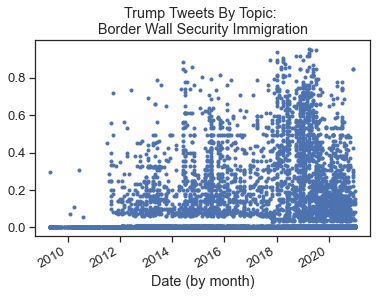

In [45]:
topic_number = 10

topic_label = " ".join(topics[topic_number][:4])

trump_df[topic_label].plot(style='.', title=f'Trump Tweets By Topic: \n{topic_label.title()}')

<AxesSubplot:title={'center':'Trump Tweets By Topic: \nBorder Wall Security Immigration'}, xlabel='Date (by month)'>

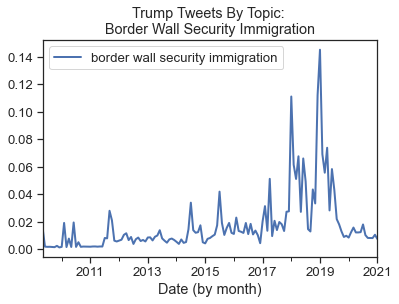

In [46]:
topic_number = 10

topic_label = " ".join(topics[topic_number][:4])

trump_df.groupby(trump_df.index)[[topic_label]].mean().plot(title=f'Trump Tweets By Topic: \n{topic_label.title()}', linewidth=2)

<AxesSubplot:title={'center':'Trump Tweets By Topic: \nElection Https Vote Votes'}, xlabel='Date (by month)'>

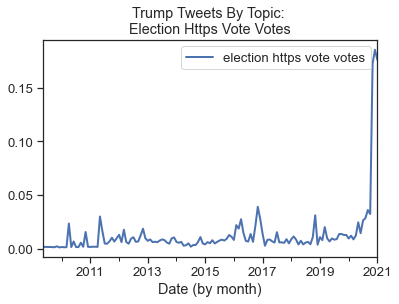

In [54]:
topic_number = 21

topic_label = " ".join(topics[topic_number][:4])

trump_df.groupby(trump_df.index)[[topic_label]].mean().plot(title=f'Trump Tweets By Topic: \n{topic_label.title()}', linewidth=2)

<AxesSubplot:title={'center':'Trump Tweets By Topic: \nFbi Witch Hunt Collusion'}, xlabel='Date (by month)'>

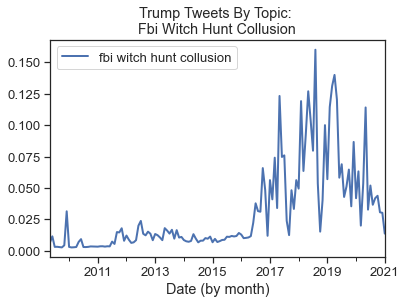

In [55]:
topic_number = 30

topic_label = " ".join(topics[topic_number][:4])

trump_df.groupby(trump_df.index)[[topic_label]].mean().plot(title=f'Trump Tweets By Topic: \n{topic_label.title()}', linewidth=2)

<AxesSubplot:title={'center':'Trump Tweets By Topic: \nCourt Supreme Justice States'}, xlabel='Date (by month)'>

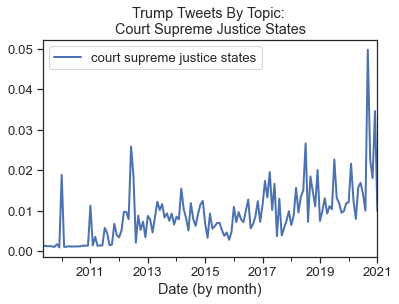

In [57]:
topic_number = 9

topic_label = " ".join(topics[topic_number][:4])

trump_df.groupby(trump_df.index)[[topic_label]].mean().plot(title=f'Trump Tweets By Topic: \n{topic_label.title()}', linewidth=2)

<AxesSubplot:title={'center':'Trump Tweets By Topic: \nBiden Joe Https Sleepy'}, xlabel='Date (by month)'>

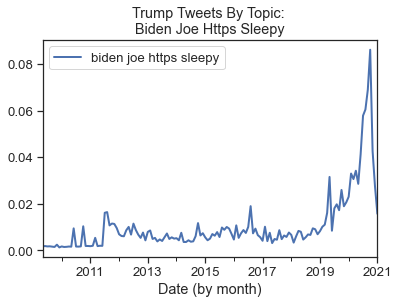

In [58]:
topic_number = 34

topic_label = " ".join(topics[topic_number][:4])

trump_df.groupby(trump_df.index)[[topic_label]].mean().plot(title=f'Trump Tweets By Topic: \n{topic_label.title()}', linewidth=2)

<AxesSubplot:title={'center':'Trump Tweets By Topic: \nChina Trade United States'}, xlabel='Date (by month)'>

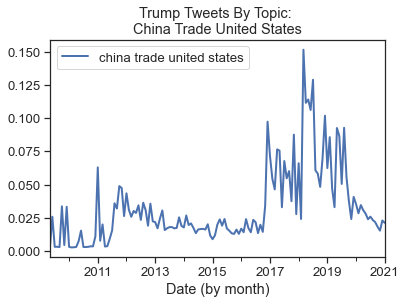

In [59]:
topic_number = 23

topic_label = " ".join(topics[topic_number][:4])

trump_df.groupby(trump_df.index)[[topic_label]].mean().plot(title=f'Trump Tweets By Topic: \n{topic_label.title()}', linewidth=2)